<a href="https://colab.research.google.com/github/pabb2002/Movie_Recommender_System/blob/main/MovieRecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommender System**

The following recommender systems will be built: 
- Knowledge/Rank based 
- Similarity-Based Collaborative filtering (User-User and Item-Item)
- Matrix Factorization Based Collaborative Filtering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 10.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633704 sha256=8ff53d2efaa7c0ef2f3a04e51a6cc699f24cfcf431cfa57d47d9cea4cd2f2cb5
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import numpy as np                              
import pandas as pd
import matplotlib.pyplot as plt              
import seaborn as sns                           

import warnings                                 
warnings.filterwarnings('ignore')
from collections import defaultdict             

# Splitting into training and test data
from surprise.model_selection import train_test_split
# Performance stats
from surprise import accuracy
# Class is used to parse rating data in the structure of user, item, rating
from surprise.reader import Reader
# Class for loading data
from surprise.dataset import Dataset
# Tuning hyperparameters
from surprise.model_selection import GridSearchCV
# Building similarity based recommender system
from surprise.prediction_algorithms.knns import KNNBasic
# Building matrix factorization based recommender system
from surprise.prediction_algorithms.matrix_factorization import SVD
# Cross validation
from surprise.model_selection import KFold

## **Loading the Data**

In [ ]:
rating = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv')

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
rating = rating.drop(['timestamp'], axis=1)

## **Exploring the Data**


In [ ]:
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


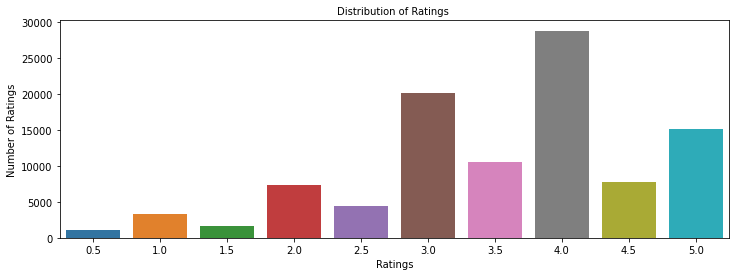

In [ ]:
plt.figure(figsize = (12, 4))

sns.countplot(rating['rating'])

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [ ]:
rating['userId'].nunique()

671

In [ ]:
rating['movieId'].nunique()

9066

**User-Movie Interactions**

In [ ]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [ ]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

In [ ]:
ratingCount = rating.groupby(['userId', 'movieId']).count()['rating']
ratingCount[ratingCount!=1]

Series([], Name: rating, dtype: int64)

No movies were interacted with more than once by the same user.

**Most Interacted Movie**

In [ ]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

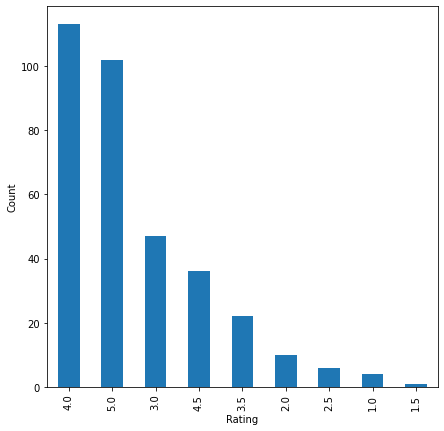

In [ ]:
plt.figure(figsize=(7,7))
rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**User with Most Interactions**

In [ ]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**Distribution of User-Movie Interactions**

In [ ]:
rating.groupby('userId').count()

,movieId,rating
userId,,
1,20,20
2,76,76
3,51,51
4,204,204
5,100,100
...,...,...
667,68,68
668,20,20
669,37,37


In [ ]:
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

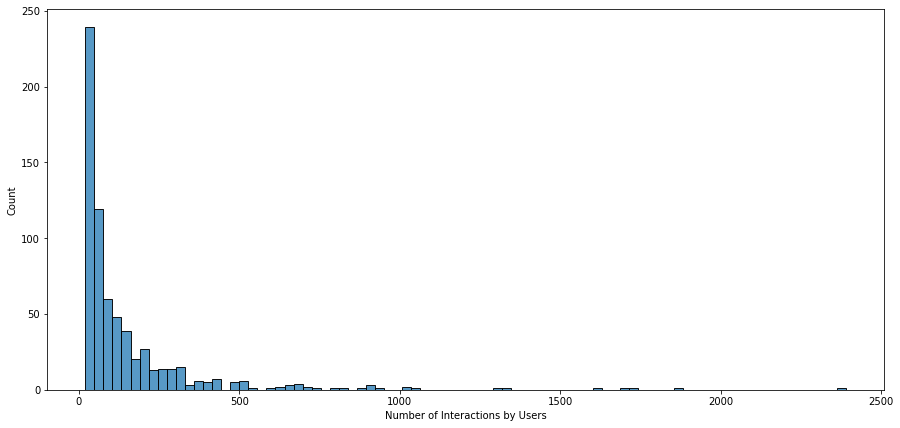

In [ ]:
plt.figure(figsize=(15,7))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

Heavily skewed to the right (very few movies with a large number of ratings)

## **Rank-Based Recommender System**

In [ ]:
# averages and counts
avg = rating.groupby('movieId').mean()['rating']
count = rating.groupby('movieId').count()['rating']

# New data frame with rating averages and counts per movie
ratings = pd.DataFrame({'average_rating':avg, 'count':count})

In [ ]:
ratings.head()

,average_rating,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [ ]:
def topMovies(data, n, min_interaction=100):
    #n is number of movies to recommend
    #min_interaction is the minimum number of interactions for a movie to be recommended

    recommended_movies = data[data['count'] > min_interaction]

    #.sort_values - sorts by avg rating
    recommended_movies = recommended_movies.sort_values(by='average_rating', ascending=False)
    return recommended_movies.index[:n]

In [ ]:
n_input = int(input("Enter a number n for the top n movies to recommend: "))
min_interaction_input = int(input("Enter a number for the minimum number of interactions: "))

n_recommended_movies = list(topMovies(ratings, n_input, min_interaction=min_interaction_input))
print("\nRecommended movies: "+ str(n_recommended_movies))

Enter a number n for the top n movies to recommend: 5
Enter a number for the minimum number of interactions: 6

Recommended movies: [98491, 1939, 3469, 86377, 858]


## **User-Based Collaborative Filtering Recommender System**

### **Building a baseline user-user similarity based recommendation system**

**Transforming the dataset into surprise dataset and splitting it into train and test set**

In [ ]:
# Instantiating Reader class as reader object, with scale 0 to 5 for ratings
reader = Reader(rating_scale=(0, 5))
# Using Dataset to load data
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting into train and test 
training_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

**Baseline similarity based recommendation system using cosine similarity and KNN**

In [ ]:
# options - cosine similarity and user-based
sim_options = {'name':'cosine','user_based':True}
#kNN Basic algorithm with above options
user_algorithm = KNNBasic(sim_options=sim_options, verbose=False)

# Training the algorithm
user_algorithm.fit(training_data)
# Predicting on test data
predicted_ratings = user_algorithm.test(test_data)
# RMSE
accuracy.rmse(predicted_ratings)

RMSE: 0.9925


0.9924509041520163

### **Predicting rating using baseline user-based recommender system, given a user and movie**

In [ ]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

predicted_rating_output = user_algorithm.predict(userId_input, movieId_input, r_ui=4, verbose=True)
print("\nPredicted rating: "+"{:.2f}".format(predicted_rating_output.est))

Enter a user Id: 8
Enter a movie Id: 4
user: 8          item: 4          r_ui = 4.00   est = 2.41   {'actual_k': 11, 'was_impossible': False}

Predicted rating: 2.41


### **Hyperparameter tuning for the baseline user based collaborative filtering recommendation system**

In [ ]:
possible_parameters = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

In [ ]:
# grid search cross validation with 3 folds
grid = GridSearchCV(KNNBasic, possible_parameters, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid.fit(data)

In [ ]:
# RMSE and MAE at each split
results_df = pd.DataFrame.from_dict(grid.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.955544,0.969120,0.969968,0.964877,0.006609,1,0.736583,0.743241,0.745803,0.741876,0.003886,1,0.167440,0.041262,3.138934,0.186699,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.983891,0.998639,0.997992,0.993507,0.006805,13,0.762305,0.769945,0.772308,0.768186,0.004269,12,0.686871,0.148413,3.295323,0.074327,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.956897,0.973031,0.976337,0.968755,0.008493,3,0.737556,0.746872,0.750490,0.744972,0.005448,3,0.182506,0.013712,3.676913,0.349719,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.983943,1.001015,1.002882,0.995947,0.008522,15,0.762069,0.772361,0.775914,0.770115,0.005871,15,0.775139,0.071557,3.170639,0.007371,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.963575,0.977209,0.982595,0.974460,0.008004,7,0.742892,0.750714,0.755196,0.749601,0.005084,6,0.211207,0.031689,3.151500,0.125638,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


In [ ]:
# Finding optimal RMSE 
print("best RMSE: "+str(grid.best_score['rmse']))

# Finding hyperparameters that gave the best RMSE 
best_parameters = grid.best_params['rmse']
print("best parameters: "+str(best_parameters))

best_k = best_parameters['k']
best_min_k = best_parameters['min_k']
sim_options = best_parameters['sim_options']

best RMSE: 0.9648774931420049
best parameters: {'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


**Tuned model**

In [ ]:
user_algorithm_optimized = KNNBasic(sim_options=sim_options, k=best_k, min_k=best_min_k, verbose=False)

# Training
user_algorithm_optimized.fit(training_data)
# Testing
predicted_ratings = user_algorithm_optimized.test(test_data)
# RMSE
accuracy.rmse(predicted_ratings)

RMSE: 0.9571


0.9571445417153293

**RMSE before tuning = 0.9925**

**RMSE after tuning = 0.9571**

### **Predicting rating using tuned user-based recommender system, given a user and movie**

In [ ]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

predicted_rating_output = user_algorithm_optimized.predict(userId_input, movieId_input, r_ui=4, verbose=True)
print("\nPredicted rating: "+"{:.2f}".format(predicted_rating_output.est))

Enter a user Id: 4
Enter a movie Id: 2
user: 4          item: 2          r_ui = 4.00   est = 4.05   {'actual_k': 20, 'was_impossible': False}

Predicted rating: 4.05


### **Identifying similar users to a given user (k- nearest neighbors) based on msd distance**

In [ ]:
userId_input = int(input("Enter the user Id: "))
k_input = int(input("Enter the value for k: "))

neighbors = user_algorithm_optimized.get_neighbors(userId_input, k=k_input)
print("\n"+str(k_input)+" similar users: "+ str(neighbors))

Enter the user Id: 3
Enter the value for k: 2

2 similar users: [118, 296]


### **Implementing the recommendation system**

In [ ]:
def get_recommendations(rating_data, user_Id, n, selected_algorithm):
    
    recommended_movies = []
    user_item_interactions_matrix = rating_data.pivot(index='userId', columns='movieId', values='rating')
    
    # Movies the user has not interacted with yet
    userId_interactions = user_item_interactions_matrix.loc[user_Id]
    non_interacted_movies = userId_interactions[userId_interactions.isnull()].index.tolist()
    
    for movie_Id in non_interacted_movies:
        # predicting ratings
        est_ratings = selected_algorithm.predict(user_Id, movie_Id).est
        recommended_movies.append((movie_Id, est_ratings))

    # Sorting - descending order
    def key_method(x):
      return x[1]
    recommended_movies.sort(key=key_method, reverse=True)
    return recommended_movies[:n] 

### **Predicting the top n movies for a given userId with user-based recommender system**

In [ ]:
userId_input = int(input("Enter a userId: "))
n_input = int(input("Enter a value for n: "))

recommendations = get_recommendations(rating, userId_input, n_input, user_algorithm_optimized)
recommendations

Enter a userId: 3
Enter a value for n: 10


[(309, 5),
 (3038, 5),
 (98491, 4.8449656287504705),
 (6273, 4.830358516694876),
 (3357, 4.822834645669292),
 (27803, 4.804772791492203),
 (116, 4.78733999168678),
 (80, 4.7704389850986715),
 (93040, 4.763636363636363),
 (1192, 4.722004953112376)]

## **Item-based Collaborative Filtering Recommender System**

### **Building a baseline item-item similarity based recommendation system**

In [ ]:
# options - cosine similarity and item-based
sim_options = {'name': 'cosine',
               'user_based': False}
item_algorithm = KNNBasic(sim_options=sim_options,verbose=False)

# Training
item_algorithm.fit(training_data)
# Testing
predicted_ratings = item_algorithm.test(test_data)
# RMSE
accuracy.rmse(predicted_ratings)

RMSE: 1.0032


1.003221450633729

### **Predicting rating using baseline item-based recommender system, given a user and movie**

In [ ]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

predicted_rating_output=item_algorithm.predict(userId_input, movieId_input, r_ui=4, verbose=True)
print("\nPredicted rating: "+"{:.2f}".format(predicted_rating_output.est))

Enter a user Id: 10
Enter a movie Id: 78
user: 10         item: 78         r_ui = 4.00   est = 3.70   {'actual_k': 31, 'was_impossible': False}

Predicted rating: 3.70


### **Hyperparameter tuning for the baseline item-based collaborative filtering recommender system**

In [ ]:
possible_parameters = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

In [ ]:
# grid search cross validation with 3 folds
grid = GridSearchCV(KNNBasic, possible_parameters, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid.fit(data)

In [ ]:
results_df = pd.DataFrame.from_dict(grid.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.949729,0.954930,0.948565,0.951075,0.002767,7,0.732362,0.738976,0.732904,0.734747,0.002998,7,7.733609,0.214280,12.453742,1.402902,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.011740,1.019529,1.013776,1.015015,0.003298,16,0.788561,0.795062,0.789324,0.790983,0.002901,16,21.468604,1.427294,11.449691,0.364153,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.949552,0.955026,0.948779,0.951119,0.002781,8,0.732364,0.739078,0.733210,0.734884,0.002986,8,6.825022,0.163206,11.710465,0.568518,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.011699,1.019589,1.013973,1.015087,0.003316,17,0.788614,0.795211,0.789597,0.791141,0.002906,17,20.314271,0.573914,11.656845,0.539850,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.950110,0.955533,0.948969,0.951537,0.002863,9,0.732800,0.739339,0.733416,0.735185,0.002948,9,6.342079,0.334032,12.091772,0.627437,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


In [ ]:
# Finding optimal RMSE 
print("best RMSE: "+str(grid.best_score['rmse']))

# Finding hyperparameters that gave the best RMSE 
best_parameters = grid.best_params['rmse']
print("best parameters: "+str(best_parameters))

best_k = best_parameters['k']
best_min_k = best_parameters['min_k']
sim_options = best_parameters['sim_options']

best RMSE: 0.9405685992004376
best parameters: {'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


**Tuned model**

In [ ]:
item_algorithm_optimized = KNNBasic(sim_options=sim_options, k=best_k, min_k=best_min_k, verbose=False)

# Training
item_algorithm_optimized.fit(training_data)
# Testing
predicted_ratings = item_algorithm_optimized.test(test_data)
# RMSE
accuracy.rmse(predicted_ratings)

RMSE: 0.9433


0.9433184999641279

**RMSE before tuning = 1.0032**

**RMSE after tuning = 0.9430**

### **Predicting rating using tuned item-based recommender system, given a user and movie**

In [ ]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

predicted_rating_output = item_algorithm_optimized.predict(userId_input, movieId_input, r_ui=4, verbose=True)
print("\nPredicted rating: "+"{:.2f}".format(predicted_rating_output.est))

Enter a user Id: 8
Enter a movie Id: 2
user: 8          item: 2          r_ui = 4.00   est = 3.85   {'actual_k': 40, 'was_impossible': False}

Predicted rating: 3.85


### **Identifying similar users to a given user (k- nearest neighbors)**


In [ ]:
userId_input = int(input("Enter the user Id: "))
k_input = int(input("Enter the value for k: "))

neighbors = item_algorithm_optimized.get_neighbors(userId_input, k=k_input)
print("\n"+str(k_input)+" similar users: "+str(neighbors))

Enter the user Id: 7
Enter the value for k: 2

2 similar users: [103, 141]


### **Predicting the top n movies for a given userId with item-based recommender system**

In [ ]:
#using the same get_recommendations method defined for user-based model

userId_input = int(input("Enter a userId: "))
n_input = int(input("Enter a value for n: "))

recommendations = get_recommendations(rating, userId_input, n_input, item_algorithm_optimized)
recommendations

Enter a userId: 6
Enter a value for n: 8


[(27186, 5),
 (57353, 4.875),
 (53, 4.75),
 (981, 4.749999999999999),
 (31374, 4.5),
 (4755, 4.490407673860911),
 (90061, 4.490407673860911),
 (568, 4.470588235294118)]

## **Model-Based Collaborative Filtering: Matrix Factorization using SVD**

### **Building a baseline matrix factorization recommender system**

In [ ]:
# Using SVD matrix factorization
SVD_algorithm = SVD()

# Training 
SVD_algorithm.fit(training_data)
# Testing
predicted_rating = SVD_algorithm.test(test_data)
# RMSE
accuracy.rmse(predicted_rating)

RMSE: 0.9012


0.9011668758531416

### **Predicting rating using baseline matrix factorization recommender system, given a user and movie**

In [ ]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

predicted_rating_output = SVD_algorithm.predict(userId_input, movieId_input, r_ui=4, verbose=True)
print("\nPredicted rating: "+"{:.2f}".format(predicted_rating_output.est))

Enter a user Id: 9
Enter a movie Id: 6
user: 9          item: 6          r_ui = 4.00   est = 3.87   {'was_impossible': False}

Predicted rating: 3.87


### **Hyperparameter tuning for the baseline SVD-based collaborative filtering recommender system**

In [ ]:
possible_parameters = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

In [ ]:
# grid search cross validation with 3 folds
grid = GridSearchCV(KNNBasic, possible_parameters, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid.fit(data)

In [ ]:
results_df = pd.DataFrame.from_dict(grid.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.980446,0.976138,0.983775,0.98012,0.003126,1,0.756604,0.750814,0.753843,0.753754,0.002365,1,0.237831,0.008431,4.818504,0.444118,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.980446,0.976138,0.983775,0.98012,0.003126,25,0.756604,0.750814,0.753843,0.753754,0.002365,25,0.336534,0.012616,4.305166,0.058163,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.980446,0.976138,0.983775,0.98012,0.003126,24,0.756604,0.750814,0.753843,0.753754,0.002365,24,0.213751,0.036999,4.046871,0.262981,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.980446,0.976138,0.983775,0.98012,0.003126,23,0.756604,0.750814,0.753843,0.753754,0.002365,23,0.249312,0.035167,3.976085,0.047205,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.980446,0.976138,0.983775,0.98012,0.003126,22,0.756604,0.750814,0.753843,0.753754,0.002365,22,0.173562,0.008797,3.861193,0.053053,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


In [ ]:
# Finding optimal RMSE 
print("best RMSE: "+str(grid.best_score['rmse']))

# Finding hyperparameters that gave the best RMSE 
best_parameters = grid.best_params['rmse']
print("best parameters: "+str(best_parameters))

best_k = best_parameters['n_epochs']
best_min_k = best_parameters['lr_all']
sim_options = best_parameters['reg_all']

best RMSE: 0.9801195694217183
best parameters: {'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}


**Tuned model**

In [ ]:
SVD_algorithm_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
SVD_algorithm_optimized.fit(training_data)
# Predicting ratings for the testset
predicted_ratings = SVD_algorithm_optimized.test(test_data)
# Computing RMSE
accuracy.rmse(predicted_ratings)

RMSE: 0.8953


0.895305245523035

**RMSE before tuning = 0.9033**

**RMSE after tuning = 0.8953**

### **Predicting rating using SVD based collaborative filtering, given a user and movie**

In [ ]:
userId_input = int(input("Enter a user Id: "))
movieId_input = int(input("Enter a movie Id: "))

SVD_algorithm_optimized.predict(userId_input, movieId_input, r_ui=4, verbose=True)
print("\nPredicted rating: "+"{:.2f}".format(predicted_rating_output.est))

Enter a user Id: 67
Enter a movie Id: 234
user: 67         item: 234        r_ui = 4.00   est = 3.17   {'was_impossible': False}

Predicted rating: 3.66


### **Predicting the top n movies for a given userId with SVD based recommender system**

In [ ]:
#using the same get_recommendation method defined for user-based model

userId_input = int(input("Enter a userId: "))
n_input = int(input("Enter a value for n: "))

recommendations = get_recommendations(rating, userId_input, n_input, SVD_algorithm_optimized)
recommendations

Enter a userId: 89
Enter a value for n: 3


[(80, 5), (116, 5), (162, 5)]

### **Predicted vs Actual Ratings** 

In [ ]:
def predicted_vs_actual(data, user_Id, selected_algorithm):
    
    recommended_movies = []
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Movies the user has already interacted with 
    userId_interactions = user_item_interactions_matrix.loc[user_Id]
    interacted_movies = userId_interactions[userId_interactions.notnull()].index.tolist()
    
    for movie_Id in interacted_movies:
        actual_ratings = user_item_interactions_matrix.loc[user_Id, movie_Id]
        est_ratings = selected_algorithm.predict(user_Id, movie_Id).est 
        recommended_movies.append((movie_Id, actual_ratings, est_ratings))

    # Sorting - descending order
    def key_method(x):
      return x[1]
    recommended_movies.sort(key=key_method, reverse=True)
    return pd.DataFrame(recommended_movies, columns=['movieId', 'actual_rating', 'predicted_rating']) 

**Input userId to compare predicted and actual ratings for a given user**

In [ ]:
userId_input = int(input("Enter a user Id: "))

Enter a user Id: 6


**Predicted vs Actual Ratings with User-Based Recommender System**

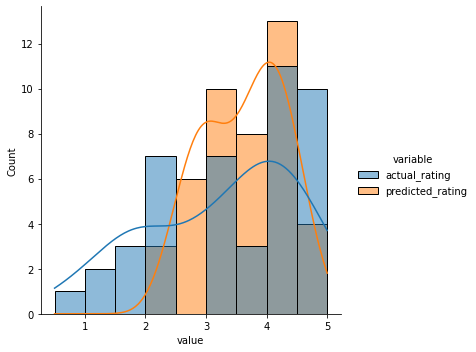

In [ ]:
predicted_ratings_for_interacted_movies = predicted_vs_actual(rating, userId_input, user_algorithm_optimized)
unpivoted_data = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=unpivoted_data, x='value', hue='variable', kde=True);

**Predicted vs Actual Ratings with Item-Based Recommender System**

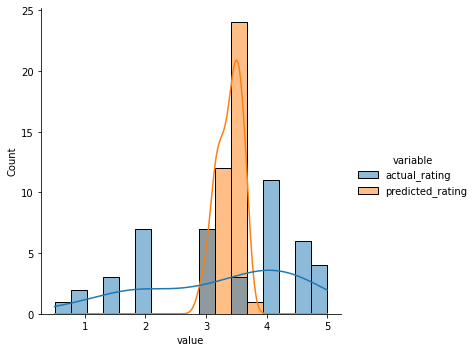

In [ ]:
predicted_ratings_for_interacted_movies = predicted_vs_actual(rating, userId_input, item_algorithm_optimized)
unpivoted_data = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=unpivoted_data, x='value', hue='variable', kde=True);

**Predicted vs Actual Ratings with Matrix Factorization-Based Recommender System**

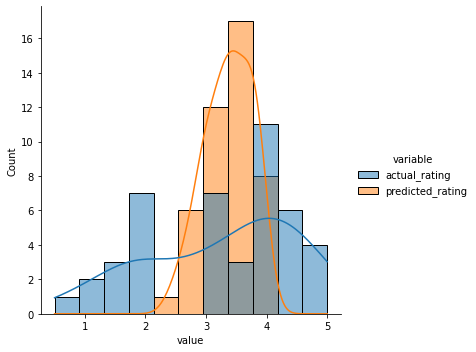

In [ ]:
predicted_ratings_for_interacted_movies = predicted_vs_actual(rating, userId_input, SVD_algorithm_optimized)
unpivoted_data = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=unpivoted_data, x='value', hue='variable', kde=True);

### **Precision and recall for each of the 6 models**

In [ ]:
def precision_and_recall_k(predicted_ratings, k, threshold):
    
    # Map predicted ratings to users
    user_est_vs_true_ratings = defaultdict(list)
    for user_Id, _, true_ratings, est_ratings, _ in predicted_ratings:
        user_est_vs_true_ratings[user_Id].append((est_ratings, true_ratings))
    precisions = dict()
    recalls = dict()

    for user_Id, user_ratings in user_est_vs_true_ratings.items():
        # Sort predicted ratings in descending order
        def key_method(x):
          return x[0]
        user_ratings.sort(key=key_method, reverse=True)

        # Number of relevant movies
        n_relevant_movies=0
        for (est_ratings, true_ratings) in user_ratings:
          if true_ratings >= threshold:
            n_relevant_movies+=1

        # Number of recommended movies in top k
        n_recommended_k=0
        for (est_ratings, true_ratings) in user_ratings[0:k]:
          if est_ratings >= threshold:
            n_recommended_k+=1

        # Number of relevant and recommended movies in top k
        n_relevant_and_recommended_k=0
        for (est_ratings, true_ratings) in user_ratings[0:k]:
          if (true_ratings >= threshold) and (est_ratings >= threshold):
            n_relevant_and_recommended_k+=1

        if n_recommended_k != 0:
          # precision at k = proportion of recommended movies that are relevant
          precisions[user_Id] = n_relevant_and_recommended_k / n_recommended_k
        else:
          # precision is undefined when number of recommended in top k is 0
          # set it to 0 since it is undefined
          precisions[user_Id] = 0

        if n_relevant_movies != 0:
          recalls[user_Id] = n_relevant_and_recommended_k / n_relevant_movies
        else:
          recalls[user_Id] = 0

    return precisions, recalls



In [ ]:
k_values = [5, 10]

# cross validator
k_fold_cv = KFold(n_splits=5)

# list of recommender systems
recommender_systems = [user_algorithm, user_algorithm_optimized, 
                       item_algorithm, item_algorithm_optimized, 
                       SVD_algorithm, SVD_algorithm_optimized]
                       
recommender_system_names = ["User-based","User-based (optimized)",
                            "Item-based","Item-based (optimized)",
                            "SVD-based","SVD-based (optimized)"]

In [ ]:
threshold_input = float(input("Enter a threshold: "))

In [ ]:
del sum

In [ ]:
for k in k_values:
    for system in range(6):
        print('\nk = {}, system = {}'.format(k, recommender_system_names[system]))
        precisions_array = []
        recalls_array = []

        for training_data, test_data in k_fold_cv.split(data):
            # train each model
            recommender_systems[system].fit(training_data)
            # test each model
            predicted_ratings = recommender_systems[system].test(test_data, verbose=False)

            precisions, recalls = precision_and_recall_k(predicted_ratings, k=k, threshold=3.5)
            
            # average precisions across users
            sum_precisions=0
            for precision in precisions.values():
              sum_precisions+=precision
            precisions_array.append(sum_precisions / len(precisions))

            # average recalls across users
            sum_recalls=0
            for recall in recalls.values():
              sum_recalls+=recall
            recalls_array.append(sum_recalls / len(recalls))

        # printing overall average precisions and recalls    
        print('-----> Precision: ', round(sum(precisions_array) / len(precisions_array), 3))
        print('-----> Recall: ', round(sum(recalls_array) / len(recalls_array), 3))


k = 5, system = User-based
-----> Precision:  0.77
-----> Recall:  0.414

k = 5, system = User-based (optimized)
-----> Precision:  0.773
-----> Recall:  0.417

k = 5, system = Item-based
-----> Precision:  0.609
-----> Recall:  0.327

k = 5, system = Item-based (optimized)
-----> Precision:  0.672
-----> Recall:  0.351

k = 5, system = SVD-based
-----> Precision:  0.755
-----> Recall:  0.387

k = 5, system = SVD-based (optimized)
-----> Precision:  0.75
-----> Recall:  0.388

k = 10, system = User-based
-----> Precision:  0.75
-----> Recall:  0.551

k = 10, system = User-based (optimized)
-----> Precision:  0.754
-----> Recall:  0.56

k = 10, system = Item-based
-----> Precision:  0.597
-----> Recall:  0.476

k = 10, system = Item-based (optimized)
-----> Precision:  0.66
-----> Recall:  0.503

k = 10, system = SVD-based
-----> Precision:  0.734
-----> Recall:  0.517

k = 10, system = SVD-based (optimized)
-----> Precision:  0.73
-----> Recall:  0.521
